https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"your_username","key":"api_key"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)    1GB  2020-04-11 13:32:24          48825  
roche-data-science-coalition/uncover                           UNCOVER COVID-19 Challenge                          123MB  2020-04-08 22:04:30           2786  
fireballbyedimyrnmom/us-counties-covid-19-dataset              US counties COVID 19 dataset                        404KB  2020-04-12 12:09:04           3128  
ryanxjhan/cbc-news-coronavirus-articles-march-26               CBC News Coronavirus/COVID-19 Articles (NLP)          6MB  2020-03-27 23:23:07            658  
bappekim/air-pollution-in-seoul               

In [0]:
!kaggle competitions download -c house-prices-advanced-regression-techniques
!ls

  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 21.0MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 62.4MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 32.1MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 63.5MB/s]
data_description.txt  sample_data	     test.csv
kaggle.json	      sample_submission.csv  train.csv


In [0]:
# import specific libraries
# load CSVs
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
# This is the format in which my submission must follow
sample = pd.read_csv('sample_submission.csv')
sample

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [0]:
# general info about the train dataset
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [0]:
# Standard 5 number summary of train dataset
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Data Cleaning

In [0]:
# I will combine both train and test for cleaning
combined = pd.concat([train.drop(columns=['SalePrice']),test])
combined

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,

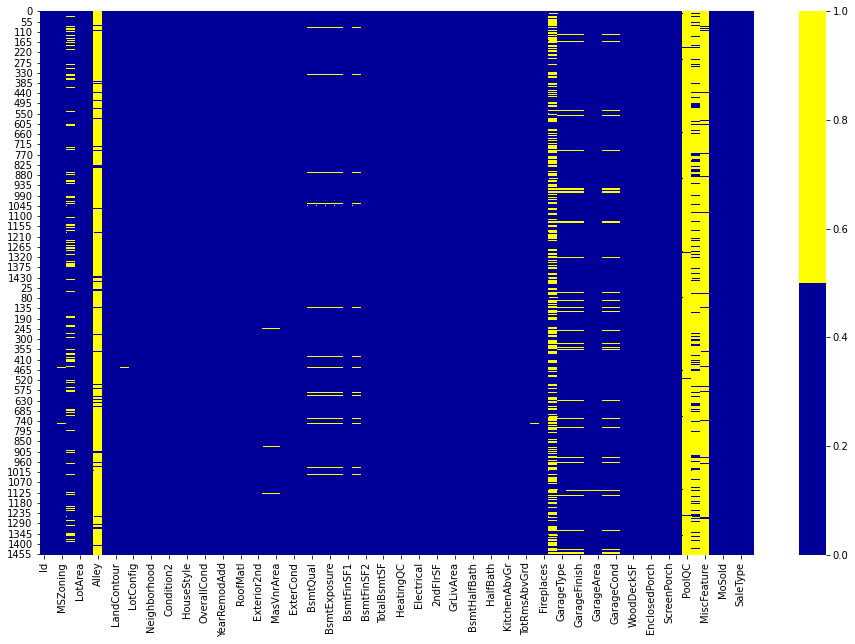

In [0]:
cols = combined.columns[:80] # first 30 columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(combined[cols].isnull(), cmap=sns.color_palette(colours))

Few observations, alley, pool QC,MiscFeature has many missing values.
LotConfig has missing values at around 465th row.


In [0]:
# A look at the columns with the highest percentages of null values
list_miss=[]
for col in combined.columns:
    pct_missing = np.mean(combined[col].isnull())
    list_miss.append([col, round(pct_missing*100)])
list_miss.sort(key = lambda x: -x[1])
list_miss

[['PoolQC', 100.0],
 ['MiscFeature', 96.0],
 ['Alley', 93.0],
 ['Fence', 80.0],
 ['FireplaceQu', 49.0],
 ['LotFrontage', 17.0],
 ['GarageType', 5.0],
 ['GarageYrBlt', 5.0],
 ['GarageFinish', 5.0],
 ['GarageQual', 5.0],
 ['GarageCond', 5.0],
 ['BsmtQual', 3.0],
 ['BsmtCond', 3.0],
 ['BsmtExposure', 3.0],
 ['BsmtFinType1', 3.0],
 ['BsmtFinType2', 3.0],
 ['MasVnrType', 1.0],
 ['MasVnrArea', 1.0],
 ['Id', 0.0],
 ['MSSubClass', 0.0],
 ['MSZoning', 0.0],
 ['LotArea', 0.0],
 ['Street', 0.0],
 ['LotShape', 0.0],
 ['LandContour', 0.0],
 ['Utilities', 0.0],
 ['LotConfig', 0.0],
 ['LandSlope', 0.0],
 ['Neighborhood', 0.0],
 ['Condition1', 0.0],
 ['Condition2', 0.0],
 ['BldgType', 0.0],
 ['HouseStyle', 0.0],
 ['OverallQual', 0.0],
 ['OverallCond', 0.0],
 ['YearBuilt', 0.0],
 ['YearRemodAdd', 0.0],
 ['RoofStyle', 0.0],
 ['RoofMatl', 0.0],
 ['Exterior1st', 0.0],
 ['Exterior2nd', 0.0],
 ['ExterQual', 0.0],
 ['ExterCond', 0.0],
 ['Foundation', 0.0],
 ['BsmtFinSF1', 0.0],
 ['BsmtFinSF2', 0.0],
 ['BsmtU

In [0]:
# Drop columns with a lot of missng data, for the sake of accuracy
# the threshold is 20%, if the data has more than 20% missing values, we drop it.
cols_to_drop = []
for i in range(len(list_miss)):
    if list_miss[i][1] > 20:
        cols_to_drop.append(list_miss[i][0])

df_less = combined.drop(cols_to_drop, axis=1)
df_less 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,700,7,2006,WD,Normal


In [0]:
# for columns in the dataframe that are of dtype float64 or int64
# fill NA with the median
def fill_median(df):
    cols = df.loc[:, df.dtypes != object].columns.tolist()
    for i in cols:
        med = df[i].median()
        df[i] = df[i].fillna(med)
    return df

In [0]:
df_median = fill_median(df_less)

In [0]:
# after filling null values of non-dtype object columns with the median
# get the dtype object columns with na values
df_median.columns[df_median.isna().any()].tolist()

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'SaleType']

In [0]:
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def __init__(self):
        """Impute missing values.
        Columns of dtype object are imputed with the most frequent value in column.
        Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)
X = pd.DataFrame(df_median)
df_final = DataFrameImputer().fit_transform(X)

In [0]:
# do a check to see if there are any more columns with missing values
df_final.columns[df_final.isna().any()].tolist()

[]

In [0]:
# checking for duplicates
# bear in mind that column Id is unique, drop it before checking
df_nodups = df_final.drop('Id', axis=1).drop_duplicates()
# there were duplicate rows
print(df_final.shape)
print(df_nodups.shape)
# 2 rows are being complete duplicate observations.

(2919, 75)
(2917, 74)


In [0]:
# upon further inspection, the 2 rows are not duplicates
df_final[df_final.drop('Id', axis=1).duplicated()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1253,2714,160,FV,24.0,2544,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,7,5,2005,2005,Gable,CompShg,MetalSd,MetalSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,600.0,600.0,GasA,Ex,Y,SBrkr,520,623,80,1223,0.0,0.0,2,1,2,1,Gd,4,Typ,0,Detchd,2005.0,RFn,2.0,480.0,TA,TA,Y,0,166,0,0,0,0,0,7,2006,WD,Normal
1405,2866,160,RM,24.0,2522,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Twnhs,2Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,Stone,50.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,970.0,970.0,GasA,Ex,Y,SBrkr,970,739,0,1709,0.0,0.0,2,0,3,1,Gd,7,Maj1,0,Detchd,2004.0,Unf,2.0,380.0,TA,TA,Y,0,40,0,0,0,0,0,5,2006,WD,Normal


In [0]:
df_numbers=df_final.loc[:, df_final.dtypes != object]
df_objects=df_final.loc[:, df_final.dtypes == object]

In [0]:
list_bins=[]
list_bin_col=[]
list_obj_col=[]
for i in df_objects.columns.tolist():
    column_values = df_objects[i].values
    unique_bins = np.unique(column_values)
    list_bins.append(np.unique(column_values))
    list_obj_col.append(i)
    for y in range(len(unique_bins)):
        list_bin_col.append(i+" "+unique_bins[y])

In [0]:
# Helper function to check for duplicates
def checkIfDuplicates_1(listOfElems):
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True
checkIfDuplicates_1(list_bin_col)
# no duplicates

False

In [0]:
# for all dtype object columns, make columns of zeros
for col in list_bin_col:
    df_final[col]=0
df_final

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,Functional Mod,Functional Sev,Functional Typ,GarageType 2Types,GarageType Attchd,GarageType Basment,GarageType BuiltIn,GarageType CarPort,GarageType Detchd,GarageFinish Fin,GarageFinish RFn,GarageFinish Unf,GarageQual Ex,GarageQual Fa,GarageQual Gd,GarageQual Po,GarageQual TA,GarageCond Ex,GarageCond Fa,GarageCond Gd,GarageCond Po,GarageCond TA,PavedDrive N,PavedDrive P,PavedDrive Y,SaleType COD,SaleType CWD,SaleType Con,SaleType ConLD,SaleType ConLI,SaleType ConLw,SaleType New,SaleType Oth,SaleType WD,SaleCondition Abnorml,SaleCondition AdjLand,SaleCondition Alloca,SaleCondition Family,SaleCondition Normal,SaleCondition Partial
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# re-index
df_final.index=list(range(len(df_final)))

In [0]:
# list_bins
# list_bin_col
# list_obj_col 
def onehotenc(df,lis1):
    for y in lis1:
        col,name=y.split(" ", 1)
        for i in range(len(df)):
            if name in df[col][i]:
                df[y][i] = 1
            else:
                df[y][i] = 0
    return df

In [0]:
# One Hot Encoding
df_updated=onehotenc(df_final,list_bin_col)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
# to test one hot encoding
total_count=0
for i in range(len(df_final)):
    if 'RL' in df_final['MSZoning'][i]:
        total_count+=1
print(total_count)
df_updated['MSZoning RL'].sum()

2269


2269

In [0]:
# finally, we have done one hot encoding, but we need to remove all object dtype columns
final_df = df_updated.drop(columns=list_obj_col)
final_df.info() 
# final check that all dtypes are either float64 or int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 2918
Columns: 271 entries, Id to SaleCondition Partial
dtypes: float64(11), int64(260)
memory usage: 6.1 MB


In [0]:
# This is what the final dataframe looks like
final_df

In [0]:
list_final_col=final_df.columns.tolist()

In [0]:
from sklearn.model_selection import train_test_split

# Grab target as y, remove target from X
y = train.SalePrice
X = final_df[:len(train)].drop(columns=['Id'])

# Split into train, test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.7, random_state = 17)
# Check
train_X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning C (all),MSZoning FV,MSZoning RH,MSZoning RL,...,Functional Mod,Functional Sev,Functional Typ,GarageType 2Types,GarageType Attchd,GarageType Basment,GarageType BuiltIn,GarageType CarPort,GarageType Detchd,GarageFinish Fin,GarageFinish RFn,GarageFinish Unf,GarageQual Ex,GarageQual Fa,GarageQual Gd,GarageQual Po,GarageQual TA,GarageCond Ex,GarageCond Fa,GarageCond Gd,GarageCond Po,GarageCond TA,PavedDrive N,PavedDrive P,PavedDrive Y,SaleType COD,SaleType CWD,SaleType Con,SaleType ConLD,SaleType ConLI,SaleType ConLw,SaleType New,SaleType Oth,SaleType WD,SaleCondition Abnorml,SaleCondition AdjLand,SaleCondition Alloca,SaleCondition Family,SaleCondition Normal,SaleCondition Partial
1386,60,80.0,16692,7,5,1978,1978,184.0,790.0,469.0,133.0,1392.0,1392,1392,0,2784,1.0,0.0,3,1,5,1,12,2,1978.0,2.0,564.0,0,112,0,0,440,519,2000,7,2006,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
609,20,61.0,7943,4,5,1961,1961,192.0,903.0,0.0,126.0,1029.0,1029,0,0,1029,1.0,0.0,1,0,3,1,5,0,1961.0,1.0,261.0,64,0,39,0,0,0,0,4,2007,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
498,20,65.0,7800,5,7,1967,2004,89.0,450.0,0.0,414.0,864.0,899,0,0,899,0.0,0.0,1,0,3,1,5,0,1967.0,1.0,288.0,64,0,0,0,0,0,0,6,2009,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
684,60,58.0,16770,7,5,1998,1998,30.0,0.0,0.0,1195.0,1195.0,1195,644,0,1839,0.0,0.0,2,1,4,1,7,0,1998.0,2.0,486.0,0,81,0,0,0,0,0,6,2010,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
76,20,68.0,8475,4,7,1956,1956,0.0,228.0,0.0,724.0,952.0,952,0,0,952,0.0,0.0,1,0,2,1,4,0,1956.0,1.0,283.0,0,0,0,0,0,0,0,4,2008,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,50,51.0,10480,6,5,1936,1950,0.0,0.0,0.0,1064.0,1064.0,1166,0,473,1639,0.0,0.0,1,0,3,1,6,0,1936.0,1.0,240.0,0,0,0,0,0,0,0,3,2008,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1414,50,64.0,13053,6,7,1923,2000,0.0,0.0,0.0,833.0,833.0,1053,795,0,1848,0.0,0.0,1,1,4,1,8,1,1922.0,2.0,370.0,0,0,0,0,220,0,0,6,2008,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
143,20,78.0,10335,7,5,1999,1999,183.0,679.0,0.0,811.0,1490.0,1501,0,0,1501,1.0,0.0,2,0,3,1,6,0,1999.0,2.0,577.0,144,29,0,0,0,0,0,6,2009,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1265,160,35.0,3735,7,5,1999,1999,218.0,450.0,0.0,241.0,691.0,713,739,0,1452,1.0,0.0,2,1,3,1,6,0,1999.0,2.0,506.0,0,34,0,0,0,0,0,3,2006,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [0]:
# Check
train_y.head()

1386    250000
609     118500
498     130000
684     221000
76      135750
Name: SalePrice, dtype: int64

In [0]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_log_error
def RMSLE(y_test, predictions):
    return np.sqrt(mean_squared_log_error( y_test, predictions ))

In [0]:
import xgboost as xgb
XGR = xgb.XGBRegressor(n_estimators=200, learning_rate=0.02)
XGR.fit(train_X, train_y)
predXG = XGR.predict(val_X)
scoreXG = RMSLE(val_y,predXG)
print('XG RMSLE:', scoreXG)
from sklearn.ensemble import RandomForestRegressor
# for n in [25,50,75,100,125,150]:
RFR = RandomForestRegressor(n_estimators=125, random_state = 17)
RFR.fit(train_X,train_y)
predRF = RFR.predict(val_X)
scoreRF = RMSLE(val_y, predRF)
print('RF RMSLE:', scoreRF)
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(train_X,train_y)
predDT = regressor.predict(val_X)
scoreDT = RMSLE(val_y, predDT)
print('DT RMSLE:', scoreDT)
from sklearn.tree import ExtraTreeRegressor
ETR = ExtraTreeRegressor( random_state = 17)
ETR.fit(train_X,train_y)
predET = ETR.predict(val_X)
scoreET = RMSLE(val_y, predET)
print('ET RMSLE:', scoreET)

[03:57:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG RMSLE: 0.14035220221113817
RF RMSLE: 0.13783126810128882
DT RMSLE: 0.19952279118108807
ET RMSLE: 0.21956751541503564


In [0]:
# log transformation
train_X = np.log(train_X)
train_X[train_X==-np.inf]=0

In [0]:
import xgboost as xgb
XGR = xgb.XGBRegressor(n_estimators=200, learning_rate=0.02)
XGR.fit(train_X, train_y)
predXG = XGR.predict(val_X)
scoreXG = RMSLE(val_y,predXG)
print('XG RMSLE:', scoreXG)
from sklearn.ensemble import RandomForestRegressor
# for n in [25,50,75,100,125,150]:
RFR = RandomForestRegressor(n_estimators=125, random_state = 17)
RFR.fit(train_X,train_y)
predRF = RFR.predict(val_X)
scoreRF = RMSLE(val_y, predRF)
print('RF RMSLE:', scoreRF)
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(train_X,train_y)
predDT = regressor.predict(val_X)
scoreDT = RMSLE(val_y, predDT)
print('DT RMSLE:', scoreDT)
from sklearn.tree import ExtraTreeRegressor
ETR = ExtraTreeRegressor( random_state = 17)
ETR.fit(train_X,train_y)
predET = ETR.predict(val_X)
scoreET = RMSLE(val_y, predET)
print('ET RMSLE:', scoreET)

[03:57:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG RMSLE: 0.7365942399652068
RF RMSLE: 1.1296408894378305
DT RMSLE: 0.9225616198121952
ET RMSLE: 1.3785757330028514


In [0]:
# If scaler is used before train_test_split, data leakage will happen. Do use scaler after train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_X=pd.DataFrame(scaler.fit_transform(train_X))
train_X.columns=list_final_col[1:]

In [0]:
import xgboost as xgb
XGR = xgb.XGBRegressor(n_estimators=200, learning_rate=0.02)
XGR.fit(train_X, train_y)
predXG = XGR.predict(val_X)
scoreXG = RMSLE(val_y,predXG)
print('XG RMSLE:', scoreXG)
from sklearn.ensemble import RandomForestRegressor
# for n in [25,50,75,100,125,150]:
RFR = RandomForestRegressor(n_estimators=125, random_state = 17)
RFR.fit(train_X,train_y)
predRF = RFR.predict(val_X)
scoreRF = RMSLE(val_y, predRF)
print('RF RMSLE:', scoreRF)
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(train_X,train_y)
predDT = regressor.predict(val_X)
scoreDT = RMSLE(val_y, predDT)
print('DT RMSLE:', scoreDT)
from sklearn.tree import ExtraTreeRegressor
ETR = ExtraTreeRegressor( random_state = 17)
ETR.fit(train_X,train_y)
predET = ETR.predict(val_X)
scoreET = RMSLE(val_y, predET)
print('ET RMSLE:', scoreET)

[04:00:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG RMSLE: 0.791432227567444
RF RMSLE: 1.147673540491515
DT RMSLE: 1.1146959255866173
ET RMSLE: 0.6380516195063747


In [0]:
# If scaler is used before train_test_split, data leakage will happen. Do use scaler after train_test_split
from sklearn.preprocessing import StandardScaler
scaler1= StandardScaler()
train_X=pd.DataFrame(scaler1.fit_transform(train_X))
train_X.columns=list_final_col[1:]

In [0]:
import xgboost as xgb
XGR = xgb.XGBRegressor(n_estimators=200, learning_rate=0.02)
XGR.fit(train_X, train_y)
predXG = XGR.predict(val_X)
scoreXG = RMSLE(val_y,predXG)
print('XG RMSLE:', scoreXG)
from sklearn.ensemble import RandomForestRegressor
# for n in [25,50,75,100,125,150]:
RFR = RandomForestRegressor(n_estimators=125, random_state = 17)
RFR.fit(train_X,train_y)
predRF = RFR.predict(val_X)
scoreRF = RMSLE(val_y, predRF)
print('RF RMSLE:', scoreRF)
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(train_X,train_y)
predDT = regressor.predict(val_X)
scoreDT = RMSLE(val_y, predDT)
print('DT RMSLE:', scoreDT)
from sklearn.tree import ExtraTreeRegressor
ETR = ExtraTreeRegressor( random_state = 17)
ETR.fit(train_X,train_y)
predET = ETR.predict(val_X)
scoreET = RMSLE(val_y, predET)
print('ET RMSLE:', scoreET)

[04:01:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG RMSLE: 0.7906517696071717
RF RMSLE: 1.118272388117681
DT RMSLE: 1.1106567836586891
ET RMSLE: 0.7884113436876609


In [0]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn
import warnings
warnings.filterwarnings('ignore')

In [0]:
pca = PCA(whiten=True)
pca.fit(final_df)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

In [0]:
pca = PCA(n_components=36,whiten=True)
pca = pca.fit(final_df)
dataPCA = pca.transform(final_df)

In [0]:
PCA_df = pd.DataFrame(dataPCA)
PCA_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,-0.216862,-1.751367,-0.104059,-0.307051,0.434815,-1.408833,-0.701837,-0.046212,0.486148,0.244040,-0.966117,-0.366659,-0.142704,-0.515471,0.111642,-0.423254,0.118727,1.142010,-0.232799,-0.339013,-0.052383,-0.047922,-1.469648,-0.059581,0.612872,-0.535849,0.308410,-1.014421,-1.374021,-1.013504,1.796045,0.339545,0.289422,0.342300,-0.389091,0.083559
1,-0.070474,-1.723388,0.073638,1.162577,-0.556514,-0.428172,-0.375192,0.150367,-0.308858,-0.758828,1.698572,0.283901,-0.391339,-0.031031,-0.110795,-0.852943,-0.090001,-0.236662,-0.306724,0.436399,-0.562990,-0.072079,-0.371779,-0.024066,1.277284,0.083763,-2.379557,0.417899,-1.109701,0.024597,0.036455,0.257200,0.581046,-0.105058,-0.097974,0.679099
2,0.137970,-1.738243,-0.081720,-0.677327,0.446028,-0.812045,-0.664191,-0.101336,0.649051,-0.063623,-0.965922,-0.186366,-0.504466,-0.515272,0.082588,-0.278627,0.130234,0.941066,-0.223915,-0.289553,-0.055350,-0.123411,1.066653,0.065398,0.070424,1.132217,0.440832,0.539883,-0.046740,-2.203078,0.587478,-0.437977,-0.013940,0.301860,-0.098221,-1.912090
3,-0.078147,-1.736351,-0.284575,-0.823456,0.485449,-0.359471,0.100813,0.212438,0.686086,-1.078776,-1.012332,3.186707,1.778621,0.222427,-1.061725,0.556575,-0.584142,0.327720,-0.025331,-0.690307,-0.087575,3.558288,-1.455695,0.036516,2.367029,0.628931,-0.040538,-0.866855,2.336933,-1.035431,-0.674540,0.738535,-0.259421,-0.507995,1.086740,0.772461
4,0.521650,-1.748601,0.638831,-0.964940,0.436155,-1.110107,-0.621350,-0.223864,1.576466,0.296424,0.206375,-0.071493,0.093882,-0.288198,0.063377,-0.407428,-0.055126,-0.023258,-0.213698,0.173855,-0.165497,-0.099944,2.112798,0.043343,-0.180137,-0.261321,0.083218,-1.010813,-0.289912,-2.362566,0.063354,0.338205,-0.062115,0.374239,0.122888,-0.723748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-1.047717,1.706031,-0.976550,-0.547346,0.465279,0.055146,-0.724413,-0.020628,-1.544561,0.887235,-0.004205,-0.464451,-0.727381,-0.485149,0.167722,2.029838,0.155967,0.328791,0.124870,-0.577052,-0.849707,0.157845,0.046187,0.006602,0.862833,-0.339037,-1.673596,1.804719,-0.600128,1.107734,-0.215566,-1.174147,0.630050,0.600065,0.110510,0.444839
2915,-1.052501,1.706868,-0.867634,-0.231324,0.402326,-0.531896,-0.779972,-0.079914,-0.197851,0.082332,-0.365533,-0.379523,-0.392392,-0.428456,0.292356,1.990959,0.113615,-0.531253,0.088965,-0.814459,-0.674304,-0.534452,-0.710301,-0.061244,1.054297,-1.611025,0.251871,0.761400,0.250300,1.420294,-0.117547,-0.797305,0.600756,1.194905,0.494150,0.295780
2916,1.245366,1.804297,-0.250430,1.345373,-0.612551,-1.004073,-0.802734,0.083719,0.333111,-0.991458,2.903786,0.463966,-0.220452,0.135639,0.094120,-1.159155,-0.163480,-0.748945,-0.142326,4.708039,1.947832,-0.326316,1.106615,-0.228561,0.882310,-1.712819,-0.276168,-0.061462,-1.848231,1.521521,0.036612,-0.345986,-0.687912,-0.699225,1.404064,-0.992807
2917,0.031639,1.774583,-0.627884,0.941114,0.834203,0.795915,-0.454281,0.314267,-1.787229,0.791438,0.534614,-0.714951,-0.209391,-0.430006,0.107183,0.844048,0.074991,1.451360,0.014822,0.692251,0.065873,-0.889024,0.424719,-0.111334,0.876594,-1.197241,0.134893,-0.097264,0.201560,0.397493,0.090864,0.644285,-2.506948,0.260859,-1.568725,-0.185676


In [0]:
from sklearn.model_selection import train_test_split

# Grab target as y, remove target from X
y = train.SalePrice
X = PCA_df[:len(train)]#.drop(columns=['Id'])

# Split into train, test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.7, random_state = 17)

In [0]:
# After PCA 
import xgboost as xgb
XGR = xgb.XGBRegressor(n_estimators=200, learning_rate=0.02)
XGR.fit(train_X, train_y)
predXG = XGR.predict(val_X)
scoreXG = RMSLE(val_y,predXG)
print('XG RMSLE:', scoreXG)
from sklearn.ensemble import RandomForestRegressor
# for n in [25,50,75,100,125,150]:
RFR = RandomForestRegressor(n_estimators=125, random_state = 17)
RFR.fit(train_X,train_y)
predRF = RFR.predict(val_X)
scoreRF = RMSLE(val_y, predRF)
print('RF RMSLE:', scoreRF)
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(train_X,train_y)
predDT = regressor.predict(val_X)
scoreDT = RMSLE(val_y, predDT)
print('DT RMSLE:', scoreDT)
from sklearn.tree import ExtraTreeRegressor
ETR = ExtraTreeRegressor( random_state = 17)
ETR.fit(train_X,train_y)
predET = ETR.predict(val_X)
scoreET = RMSLE(val_y, predET)
print('ET RMSLE:', scoreET)

[03:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG RMSLE: 0.1770128336042066
RF RMSLE: 0.1739832696232296
DT RMSLE: 0.24562266615757103
ET RMSLE: 0.2563861695420986


In [0]:
msy = train.SalePrice
msX = final_df[:len(train)].drop(columns=['Id'])

,R Square Score
Linear,-1.268911e+07
Ridge,8.094465e-01
Bayesian Ridge,8.088403e-01
Hubber,6.741035e-01
Lasso,8.050099e-01
Bagging,8.420227e-01
RandomForest,8.463364e-01
AdaBoost,7.983250e-01
SVM RBF,-5.345605e-02
SVM Linear,7.172208e-01


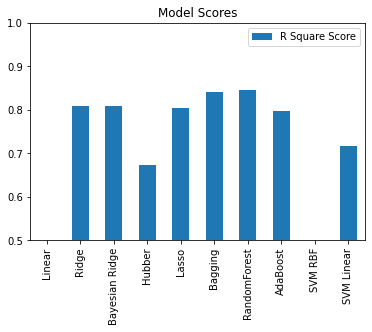

In [0]:
def model_selection(train,labels):
    results={}
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores

    clf = linear_model.LinearRegression()
    results["Linear"]=test_model(clf)
    
    clf = linear_model.Ridge()
    results["Ridge"]=test_model(clf)
    
    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"]=test_model(clf)
    
    clf = linear_model.HuberRegressor()
    results["Hubber"]=test_model(clf)
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"]=test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"]=test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"]=test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"]=test_model(clf)
    
    clf = svm.SVR()
    results["SVM RBF"]=test_model(clf)
    
    clf = svm.SVR(kernel="linear")
    results["SVM Linear"]=test_model(clf)
    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["R Square Score"] 
    # results=results.sort(columns=["R Square Score"],ascending=False)
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    return results

model_selection(msX,msy)

Random Forest regressor works the best here.

In [0]:
# If scaler is used before train_test_split, data leakage will happen. Do use scaler after train_test_split
from sklearn.preprocessing import StandardScaler
scaler1= StandardScaler()
train_X=pd.DataFrame(scaler1.fit_transform(train_X))
train_X.columns=list_final_col[1:]

In [0]:
from keras.layers import Dense, Activation
from keras.models import Sequential
# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim = 270))

# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the output layer
model.add(Dense(units = 1))

In [0]:
# mean_squared_logarithmic_error
model.compile(optimizer = 'adam',loss = 'mean_squared_logarithmic_error')

In [0]:
model.fit(train_X, train_y, batch_size = 10, epochs = 100)

Epoch 1/100
1021/1021 [==============================] - 2s 2ms/step - loss: 100.8299
Epoch 2/100
1021/1021 [==============================] - 0s 268us/step - loss: 60.2975
Epoch 3/100
1021/1021 [==============================] - 0s 252us/step - loss: 42.0162
Epoch 4/100
1021/1021 [==============================] - 0s 262us/step - loss: 31.5482
Epoch 5/100
1021/1021 [==============================] - 0s 279us/step - loss: 24.6442
Epoch 6/100
1021/1021 [==============================] - 0s 263us/step - loss: 19.7151
Epoch 7/100
1021/1021 [==============================] - 0s 259us/step - loss: 16.1922
Epoch 8/100
1021/1021 [==============================] - 0s 267us/step - loss: 13.5534
Epoch 9/100
1021/1021 [==============================] - 0s 277us/step - loss: 11.5007
Epoch 10/100
1021/1021 [==============================] - 0s 259us/step - loss: 9.8552
Epoch 11/100
1021/1021 [==============================] - 0s 273us/step - loss: 8.5089
Epoch 12/100
1021/1021 [====================

In [0]:
nn_pred = model.predict(val_X)

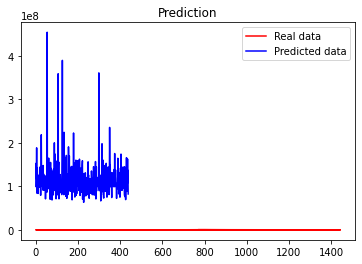

In [0]:
plt.plot(val_y, color = 'red', label = 'Real data')
plt.plot(nn_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [0]:
for_test=final_df[1460:].drop(columns=['Id'])
pred_sub = RFR.predict(for_test)
result = pd.DataFrame(pred_sub)
result.columns = ['SalePrice']
result.index=list(range(1461,len(final_df)+1))
result

,SalePrice
1461,129334.800
1462,153322.256
1463,179632.736
1464,183140.176
1465,209498.992
...,...
2915,86813.200
2916,85406.656
2917,152888.696
2918,113584.800


In [0]:
sample

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [0]:
test.index = list(range(1461,len(final_df)+1))
sub = pd.concat([test,result],axis=1)
forsub = sub[['Id','SalePrice']]
forsub.index=list(range(len(forsub)))
forsub

,Id,SalePrice
0,1461,129334.800
1,1462,153322.256
2,1463,179632.736
3,1464,183140.176
4,1465,209498.992
...,...,...
1454,2915,86813.200
1455,2916,85406.656
1456,2917,152888.696
1457,2918,113584.800


In [0]:
forsub.to_csv('submission.csv', index=False)

In [0]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Message"

100% 21.9k/21.9k [00:01<00:00, 11.4kB/s]
Successfully submitted to House Prices: Advanced Regression Techniques